In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil, prod
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.decomposition import PCA
import torch

import scripts.dns_specifics as DS
from model import *

np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda:0


# Load Data

In [3]:
%%capture --no-display
base_shape = (128, 128)
axis_array = 2 * [np.linspace(0, 2*np.pi, 128+1)[:-1]]
dx = axis_array[0][1]-axis_array[0][0]
dy = axis_array[1][1]-axis_array[1][0]
snapshots = []

# Load data
for i in range(200):
    binary = open(f'./turbulence_data/vortJP_0000.{str(i).zfill(3)}', 'rb')
    binary.seek(0)
    snap = np.fromfile(binary, dtype='float64', count=128**2).reshape(128, 128)
    # snap = DS.all_syms(snap,
    #     base_shape=base_shape,
    #     dx=dx,
    #     dy=dy,
    #     x_shift=0,
    #     m=1)
    snapshots.append(snap)
    
# Format data
snapshots = torch.Tensor(snapshots).unsqueeze(1)
snapshots /= snapshots.absolute().max()
test_snapshots = snapshots

# Visualize Data

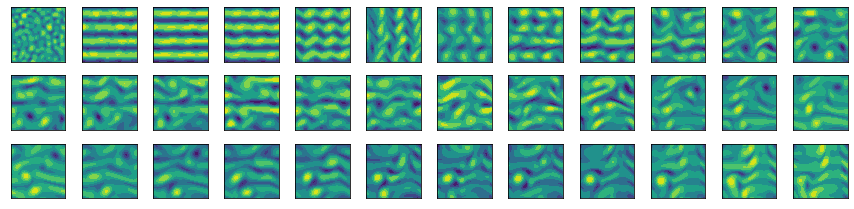

In [4]:
# Visualize select snapshots
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (3, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i][0])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

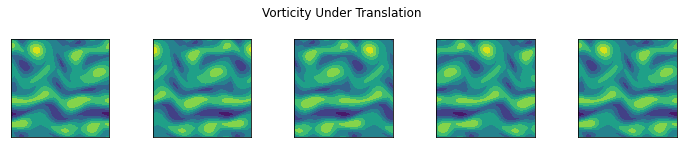

In [5]:
# Visualize shift
fig_shape = (1, 5)
fig = plt.figure(figsize=(10, 2))
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    snap = DS.translate_fx(snapshots[9][0], base_shape=base_shape, dx=dx, x_shift=(np.pi/2)*i)
    ax.contourf(*axis_array, snap)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('; '.join([f'{x:.02f}' for x in translate_vector]))
fig.suptitle('Vorticity Under Translation')
fig.tight_layout()
plt.show()

# Train

In [6]:
epochs = 801
batch_size = 64
embedded_dim = 96
lr = .0003
epoch_pd = 100

In [7]:
autoencoder = AEModel(embedded_dim=embedded_dim).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [8]:
%%time
try:
    # Load model
    autoencoder.load_state_dict(torch.load(f'./model_{embedded_dim}_{epochs}-{batch_size}-{lr}.h5'))
    autoencoder.eval();
except:
    # Train model
    autoencoder.train()
    batches = ceil(len(snapshots) / batch_size)
    for epoch in range(epochs):
        for _ in range(batches):
            batch = snapshots[np.random.choice(range(len(snapshots)), batch_size)].to(device)
            _, logits = autoencoder(batch)
            loss = (logits - batch).square().sum() / prod(batch.shape)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % epoch_pd == 0:
            print(f'Epoch: {epoch} \tLoss:{float(loss.detach())}')

    # Save model
    torch.save(autoencoder.state_dict(), f'./model_{embedded_dim}_{epochs}-{batch_size}-{lr}.h5')
    autoencoder.eval();

CPU times: total: 750 ms
Wall time: 749 ms


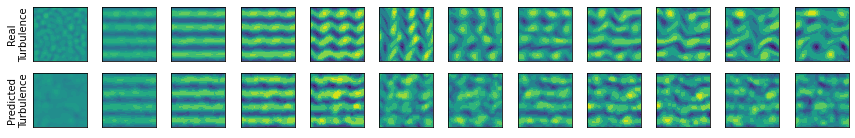

In [9]:
# Preview reconstruction
fig_shape = (2, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(fig_shape[1]):
    # Actual
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Real\nTurbulence')
    
    # Predicted
    ax = fig.add_subplot(*fig_shape, fig_shape[1]+i+1)
    ax.contourf(*axis_array, autoencoder(snapshots[[i]].to(device))[1].detach().cpu()[0, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Predicted\nTurbulence')
fig.tight_layout()
plt.show()

# Eigenanalysis

In [10]:
autoencoder = autoencoder.cpu()

In [11]:
# Construct shift operator
n = 9
alpha = 2*np.pi/n
omega = test_snapshots
omega_test = test_snapshots[:5]
omega_prime = torch.stack([torch.Tensor(DS.translate_fx(z, base_shape=base_shape, dx=dx, x_shift=alpha)) for z in omega]).unsqueeze(1)
E = autoencoder(omega)[0].T
E_test = autoencoder(omega_test)[0].T
E_prime = autoencoder(omega_prime)[0].T
E_plus = torch.linalg.pinv(E)
T = E_prime @ E_plus
fit_quality = (torch.matmul(T, E) - E_prime).absolute().mean()
print(f'Shift operator average error: {fit_quality:.4f}')
print(f'E average value: {E.absolute().mean():.4f}')

Shift operator average error: 0.3448
E average value: 3.5564


In [24]:
# https://datascience.stackexchange.com/a/75751
def PCA(X):
    mean = X.mean(axis=0) 
    center = X - mean
    _, stds, pcs = np.linalg.svd(center/np.sqrt(X.shape[0]))
    return stds**2, pcs

# Get eigenvalues
Lambda, V = [t.detach() for t in torch.linalg.eig(T)]
W = torch.linalg.eig(T.T)[1].detach()
wavenumbers = (torch.log(Lambda) / (1j*alpha))
tol = .05
P = []
used_l = []
for l in range(10):
    idx = np.argwhere(np.abs(wavenumbers.real - l) < tol).squeeze()
    if l == 0:
        assert idx.shape[0] > 1
    # Only consider degenerate eigenvalues
    if len(idx.shape) < 1 or idx.shape[0] < 2:
        continue
    d = idx.shape[0]  # Geometric multiplicity
    # idx = [idx[np.argmin(np.abs(wavenumbers[idx].imag))]]  # Use smallest imaginary component
    
    # Construct basis
    # V_l, W_l = V[:, idx], W[:, idx]
    # Q, R = torch.linalg.qr(W_l.conj().T @ V_l)
    # Xi_l = V_l @ torch.inverse(R)
    # Xi_dagger_l = (torch.inverse(Q) @ W_l.conj().T).conj().T
    
    # Set eigspace
    # eigspace = V_l
    # eigspace = eigspace.numpy()
    
    # Perform PCA
    # eigspace = PCA(eigspace.T)[1][:5].T
    # eigspace = PCA(T.detach())[1][:5].T
    
    Z = T - T.mean(dim=0)
    lam, v = torch.linalg.eig(Z.T @ Z)
    # print(wavenumbers)
    # print((torch.log(lam) / (1j*alpha)))
    eigspace = v[:, idx].detach().numpy()
    
    # Project
    projector = (E_test.T.detach() @ eigspace) @ eigspace.T  # sum_j P_j^l
    P.append(projector.real)
    used_l.append(l)
print(f'Applicable wavenumbers: {used_l}')

# l=0 contribuation
# for i in range(1, len(P)):
#     P[i] += P[0]

RuntimeError: expected scalar type Float but found ComplexFloat

In [19]:
torch.Tensor([[1,2],[3,4],[5,6]]).mean(dim=0).shape

torch.Size([2])

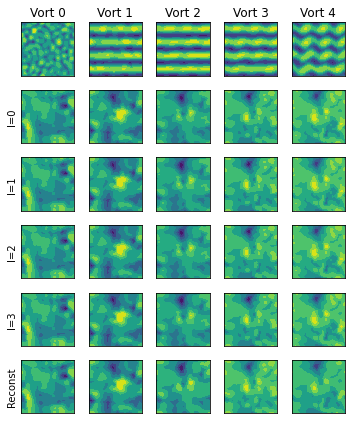

In [14]:
# Preview reconstruction
fig_shape = (len(P)+2, omega_test.shape[0])
fig = plt.figure(figsize=fig_shape[::-1])
agg_decodes = torch.zeros(omega_test.shape)
for i in range(fig_shape[0]):
    # Actual
    if i == 0:
        for j, vort in enumerate(omega_test):
            ax = fig.add_subplot(*fig_shape, j+1)
            ax.contourf(*axis_array, vort[0, :, :])
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Vort {j}')
    
    # Predicted
    elif i != fig_shape[0]-1:
        decodes = autoencoder.decoder(P[i-1]).detach().cpu()
        agg_decodes += decodes
        for j, vort in enumerate(decodes):
            ax = fig.add_subplot(*fig_shape, i*fig_shape[1]+1+j)
            ax.contourf(*axis_array, vort[0, :, :])
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(f'l={used_l[i-1]}')
    # Reconstructed
    else:
        for j, vort in enumerate(agg_decodes):
            ax = fig.add_subplot(*fig_shape, i*fig_shape[1]+1+j)
            ax.contourf(*axis_array, vort[0, :, :])
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(f'Reconst')
fig.tight_layout()
plt.show()

# Not in Use

In [ ]:
# # Get wavenumbers
# Lambda, V = torch.linalg.eig(T)
# Lambda = torch.diag(Lambda)
# l_full, idx_full = np.unique((torch.log(Lambda) / (1j*alpha)).detach().diag().cpu(), return_index=True)
# l_full, idx_full = l_full[:-1], idx_full[:-1]
# l_filt = []
# idx_filt = []
# for l in np.unique(l_full.real):
#     idx = np.argmin(np.abs(l_full[l_full.real == l].imag))
#     if np.abs(l_full[l_full.real == l][idx].imag) < 20:
#         l_filt.append(l_full[l_full.real == l][idx])
#         idx_filt.append(idx_full[l_full.real == l][idx])
# print(f'Latent wavenumbers: {l_filt}')

# # Construct basis
# DP = []
# Xi = []
# Xi_dagger = []
# W = torch.linalg.eig(T.T)[1]
# for l, idx in zip(l_filt, idx_filt):
#     V_l, W_l = V[:, idx:idx+1], W[:, idx:idx+1]
#     Q, R = torch.linalg.qr(W_l.conj().T @ V_l)
#     Xi_l = V_l @ torch.inverse(R)
#     Xi_dagger_l = (torch.inverse(Q) @ W_l.conj().T).conj().T
#     Xi.append(Xi_l)
#     Xi_dagger.append(Xi_dagger_l)
#     # Project
#     projector = (E_test.T @ V_l.real) @ V_l.real.T
#     DP.append(projector)
#     # pca = PCA(n_components=1).fit(projector.detach().cpu()).components_
# Xi = torch.cat(Xi, 1)
# Xi_dagger = torch.cat(Xi_dagger, 1)